In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pybrain.structure import RecurrentNetwork, FeedForwardNetwork
from pybrain.structure import FullConnection
from pybrain.structure import LinearLayer, SigmoidLayer, LSTMLayer, BiasUnit
from pybrain.supervised          import RPropMinusTrainer, BackpropTrainer
import pybrain
from datasets import generateNoisySines
from pybrain.tools.validation    import testOnSequenceData
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.tools.neuralnets import NNregression

In [4]:
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utils

In [5]:
def RA(y, yp):
    m = len(y)
    res = 0
    for i in range(m):
        if y[i] == 0:
            continue
        res += np.abs(y[i]-yp[i])/y[i]
    return (res / m)[0]
def AcFP(real, predicted):
    return (np.abs(real - predicted) / real * 100)

# Custom layer

In [6]:
from pybrain.structure.modules.neuronlayer import NeuronLayer

In [7]:
def go(x):
    return 1-np.exp(-x)
def d_go(x):
    return np.exp(-x)

def yamada(x):
    return 1 - np.multiply((1+x),np.exp(-x))
def d_yamada(x):
    return np.multiply(np.exp(-x),x)

def s_shaped(x):
    return np.divide(1, 1 + np.exp(-x))
def d_s_shaped(x):
    return np.divide(np.exp(x), np.square(np.exp(x)+1))

def d_gen(x):
    return np.multiply(np.exp(-x), x+1) + np.divide(np.exp(-x), np.square(np.exp(-x)+1))

def unknown(x):
    return np.divide(1-np.exp(-x),1+np.exp(-x))
def d_unknown(x):
    return np.divide(np.exp(x),np.square(np.exp(x)+1))

In [8]:
class CustomLayer(NeuronLayer):
    """Layer implementing the sigmoid squashing function."""
    
    def _forwardImplementation(self, inbuf, outbuf):
        g = go(inbuf[0])
        y = yamada(inbuf[1])
        s = s_shaped(inbuf[2])
#         u = unknown(inbuf[3])
        outbuf[:] = np.hstack([g, y, s])

    def _backwardImplementation(self, outerr, inerr, outbuf, inbuf):
#         g = d_go(outbuf[0])
#         y = d_yamada(outbuf[1])
#         s = d_s_shaped(outbuf[2])
#         u = d_unknown(outbuf[3])
#         inerr[:] = np.hstack([g,y,s,u]) * outerr
#         inerr[:] = (d_go(outbuf) + d_yamada(outbuf) + d_s_shaped(outbuf) )*outerr
        inerr[:] = d_gen(outbuf) * outerr
#         inerr[:] = outbuf * (1 - outbuf) * outerr

In [9]:
# tizen = pd.read_csv("bugs-1-tizen.csv", delimiter=';')
# tizen = pd.read_csv("bugs-2-cyanogen.csv", delimiter=';')
tizen = pd.read_csv("SS1.DAT", sep = '\t', names=['x', 'z', 'y'])
x = tizen.y.values

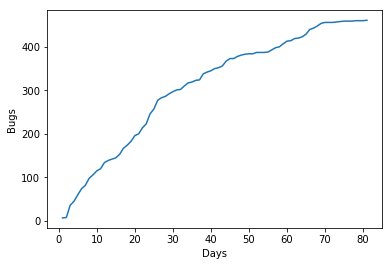

In [10]:
plt.plot(tizen.x, tizen.y)
plt.ylabel('Bugs')
plt.xlabel('Days')
plt.show()

In [11]:
t = tizen.x.values
x = tizen.y.values

In [12]:
t = preprocessing.minmax_scale(t)
x = preprocessing.minmax_scale(x)
X = t
Y = x

/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


In [20]:
points_to_learn = 80*len(X)//100
X_train, X_test = X[:points_to_learn], X[points_to_learn:]
y_train, y_test = Y[:points_to_learn], Y[points_to_learn:]

In [21]:
train_ds = pybrain.datasets.SequentialDataSet(1, 1)
for i in range(len(X_train)):
    train_ds.addSample(X_train[i],y_train[i])

test_ds = pybrain.datasets.SequentialDataSet(1, 1)
for i in range(len(X_test)):
    test_ds.addSample(X_test[i],y_test[i])

In [22]:
n = RecurrentNetwork()
n.addInputModule(LinearLayer(1, name='in'))
n.addModule(SigmoidLayer(10, name='hidden1'))
# n.addModule(SigmoidLayer(3, name='hidden2'))
n.addOutputModule(LinearLayer(1, name='out'))
n.addModule(BiasUnit(name='bias1'))
# n.addModule(BiasUnit(name='bias2'))
n.addModule(BiasUnit(name='bias3'))
n.addConnection(FullConnection(n['in'], n['hidden1'], name='c1'))
n.addConnection(FullConnection(n['hidden1'], n['out'], name='c2'))
# n.addConnection(FullConnection(n['hidden2'], n['out'], name='c3'))
n.addConnection(FullConnection(n['bias1'], n['hidden1'], name='c4'))
# n.addConnection(FullConnection(n['bias2'], n['hidden2'], name='c5'))
n.addConnection(FullConnection(n['bias3'], n['out'], name='c6'))
n.addRecurrentConnection(FullConnection(n['hidden1'], n['hidden1'], name='c7'))
n.sortModules()

In [23]:
trainer = RPropMinusTrainer( n, dataset=train_ds, verbose=True, learningrate=0.1 )
# trainer = BackpropTrainer(n, dataset=train_ds, verbose=True, learningrate=0.01)
count = 0

In [24]:
from __future__ import print_function
for i in range(20):
    count += 1
    print("Epoch",count, end=' ')
    trainer.trainEpochs( 1 )

Epoch 1 epoch      0  total error       2.5183   avg weight        1.0396
Epoch 2 epoch      1  total error       0.4296   avg weight         1.042
Epoch 3 epoch      2  total error     0.042749   avg weight        1.0526
Epoch 4 epoch      3  total error      0.52637   avg weight        1.0584
Epoch 5 epoch      4  total error      0.12646   avg weight         1.058
Epoch 6 epoch      5  total error     0.031126   avg weight        1.0718
Epoch 7 epoch      6  total error      0.17277   avg weight        1.0951
Epoch 8 epoch      7  total error     0.048565   avg weight        1.0965
Epoch 9 epoch      8  total error     0.030756   avg weight        1.0859
Epoch 10 epoch      9  total error     0.063024   avg weight        1.0856
Epoch 11 epoch     10  total error     0.024825   avg weight         1.086
Epoch 12 epoch     11  total error     0.026273   avg weight        1.0843
Epoch 13 epoch     12  total error     0.026769   avg weight        1.0944
Epoch 14 epoch     13  total error

In [18]:
y_pred = []
n.reset()
for x in np.hstack([X_train, X_test]):
    y_pred.append(n.activate([x]))

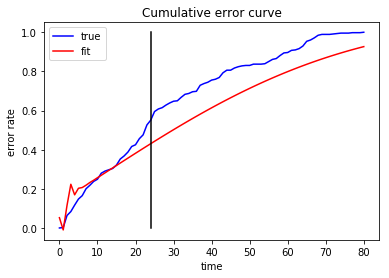

In [19]:
plt.plot(Y, "b-", y_pred, "r-") # Plot of the data and the fit
plt.title("Cumulative error curve")
plt.xlabel("time")
plt.ylabel("error rate")
plt.plot([points_to_learn, points_to_learn], [0, 1], 'k-')
plt.legend(('true', 'fit'), loc=2)
plt.show()

In [631]:
mean_absolute_error(y_train, y_pred[:points_to_learn]), \
        mean_absolute_error(y_test, y_pred[points_to_learn:]), \
        AcFP(y_test[-1], y_pred[-1])

(0.036534291219701205, 0.19406410393598456, array([ 47.7258929]))

In [639]:
def ffn(X,Y, part):
    points_to_learn = part*len(X)/100
    X_train, X_test = X[:points_to_learn], X[points_to_learn:]
    y_train, y_test = Y[:points_to_learn], Y[points_to_learn:]

    train_ds = pybrain.datasets.SequentialDataSet(1, 1)
    for i in range(len(X_train)):
        train_ds.addSample(X_train[i],y_train[i])

    test_ds = pybrain.datasets.SequentialDataSet(1, 1)
    for i in range(len(X_test)):
        test_ds.addSample(X_test[i],y_test[i])

    n = RecurrentNetwork()
    n.addInputModule(LinearLayer(1, name='in'))
    n.addModule(LSTMLayer(10, name='hidden1'))
    # n.addModule(SigmoidLayer(3, name='hidden2'))
    n.addOutputModule(LinearLayer(1, name='out'))
    n.addModule(BiasUnit(name='bias1'))
    # n.addModule(BiasUnit(name='bias2'))
    n.addModule(BiasUnit(name='bias3'))
    n.addConnection(FullConnection(n['in'], n['hidden1'], name='c1'))
    n.addConnection(FullConnection(n['hidden1'], n['out'], name='c2'))
    # n.addConnection(FullConnection(n['hidden2'], n['out'], name='c3'))
    n.addConnection(FullConnection(n['bias1'], n['hidden1'], name='c4'))
    # n.addConnection(FullConnection(n['bias2'], n['hidden2'], name='c5'))
    n.addConnection(FullConnection(n['bias3'], n['out'], name='c6'))
#     n.addRecurrentConnection(FullConnection(n['hidden1'], n['hidden1'], name='c7'))
    n.sortModules()

    trainer = RPropMinusTrainer( n, dataset=train_ds, verbose=False, learningrate=0.01 )
    # trainer = BackpropTrainer(n, dataset=train_ds, verbose=True, learningrate=0.01)
    count = 0

#     print('training started')
    for i in range(120):
        count += 1
#         print("Epoch",count, end=' ')
        trainer.trainEpochs( 1 )

    y_pred = []
    n.reset()
    for x in np.hstack([X_train, X_test]):
        y_pred.append(n.activate([x]))

    return mean_absolute_error(y_train, y_pred[:points_to_learn]), \
        mean_absolute_error(y_test, y_pred[points_to_learn:]), \
        AcFP(y_test[-1], y_pred[-1])[0]

In [641]:
for i in range(10,100, 10):
    print(i, ffn(X,Y,i) )

10 (0.0064360052612059092, 0.2730900951651708, 48.871350476748951)
20 (0.015049780057192846, 0.3882524831617824, 56.253901152954896)
30 (0.0083642620040933532, 0.26575097692953953, 57.647628565799124)
40 (0.014384538477798133, 0.25525085946693721, 46.696802634755755)
50 (0.0085521938622244217, 0.13641179365795353, 23.435934072468235)
60 (0.01511458960579362, 0.051482450215771691, 9.8420157748046133)
70 (0.018281036433502755, 0.014416727219987826, 0.66268797419968273)
80 (0.020396780205013221, 0.03808086167088761, 2.3074842183355537)
90 (0.019827880603184616, 0.033093231837962596, 3.0596366479304526)


# Custom layer recurrent

In [64]:
tizen = pd.read_csv("bugs-1-tizen.csv", delimiter=';')
# tizen = pd.read_csv("bugs-2-cyanogen.csv", delimiter=';')
# tizen = pd.read_csv("SS1.DAT", sep = '\t', names=['x', 'z', 'y'])
x = tizen.y.values

In [65]:
t = tizen.x.values
x = tizen.y.values

In [66]:
t = preprocessing.minmax_scale(t)
x = preprocessing.minmax_scale(x)
X = t[np.arange(0, len(t), 10)]
Y = x[np.arange(0, len(t), 10)]

In [67]:
points_to_learn = 80*len(X)/100
X_train, X_test = X[:points_to_learn], X[points_to_learn:]
y_train, y_test = Y[:points_to_learn], Y[points_to_learn:]

In [68]:
train_ds = pybrain.datasets.SequentialDataSet(1, 1)
for i in range(len(X_train)):
    train_ds.addSample(X_train[i],y_train[i])

test_ds = pybrain.datasets.SequentialDataSet(1, 1)
for i in range(len(X_test)):
    test_ds.addSample(X_test[i],y_test[i])

In [78]:
n = RecurrentNetwork()
n.addInputModule(LinearLayer(1, name='in'))
n.addModule(CustomLayer(3, name='hidden1'))
# n.addModule(SigmoidLayer(3, name='hidden2'))
n.addOutputModule(LinearLayer(1, name='out'))
# n.addModule(BiasUnit(name='bias1'))
# n.addModule(BiasUnit(name='bias2'))
n.addModule(BiasUnit(name='bias3'))
n.addConnection(FullConnection(n['in'], n['hidden1'], name='c1'))
n.addConnection(FullConnection(n['hidden1'], n['out'], name='c2'))
# n.addConnection(FullConnection(n['hidden2'], n['out'], name='c3'))
# n.addConnection(FullConnection(n['bias1'], n['hidden1'], name='c4'))
# n.addConnection(FullConnection(n['bias2'], n['hidden2'], name='c5'))
n.addConnection(FullConnection(n['bias3'], n['out'], name='c6'))
n.addRecurrentConnection(FullConnection(n['hidden1'], n['hidden1'], name='c7'))
n.sortModules()

In [79]:
trainer = RPropMinusTrainer( n, dataset=train_ds, verbose=True , learningrate=0.1)
# trainer = BackpropTrainer(n, dataset=train_ds, verbose=True, learningrate=0.01)
count = 0

In [80]:
from __future__ import print_function
for i in range(120):
    count += 1
    n.reset()
    print("Epoch",count, end=' ')
    trainer.trainEpochs( 1 )

Epoch 1 epoch      0  total error          nan   avg weight       0.82216
Epoch 2 epoch      1  total error          nan   avg weight           nan
Epoch 3 epoch      2  total error          nan   avg weight           nan
Epoch 4 

/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/numpy/core/numeric.py:1093: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-pack

epoch      3  total error          nan   avg weight           nan
Epoch 5 epoch      4  total error          nan   avg weight           nan
Epoch 6 epoch      5  total error          nan   avg weight           nan
Epoch 7 epoch      6  total error          nan   avg weight           nan
Epoch 8 epoch      7  total error          nan   avg weight           nan
Epoch 9 epoch      8  total error          nan   avg weight           nan
Epoch 10 epoch      9  total error          nan   avg weight           nan
Epoch 11 epoch     10  total error          nan   avg weight           nan
Epoch 12 epoch     11  total error          nan   avg weight           nan
Epoch 13 epoch     12  total error          nan   avg weight           nan
Epoch 14 epoch     13  total error          nan   avg weight           nan
Epoch 15 epoch     14  total error          nan   avg weight           nan
Epoch 16 epoch     15  total error          nan   avg weight           nan
Epoch 17 epoch     16  total error     

KeyboardInterrupt: 

In [62]:
y_pred = []
n.reset()
for x in np.hstack([X_train, X_test]):
    y_pred.append(n.activate([x]))

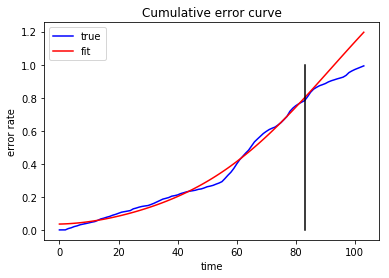

In [63]:
plt.plot(Y, "b-", y_pred, "r-") # Plot of the data and the fit
plt.title("Cumulative error curve")
plt.xlabel("time")
plt.ylabel("error rate")
plt.plot([points_to_learn, points_to_learn], [0, 1], 'k-')
plt.legend(('true', 'fit'), loc=2)
plt.show()

In [55]:
mean_absolute_error(y_train, y_pred[:points_to_learn]), \
        mean_absolute_error(y_test, y_pred[points_to_learn:]), \
        AcFP(y_test[-1], y_pred[-1])[0]

(0.022432716423313837, 0.048491092964889994, 11.647492984348567)

# leastsq

In [82]:
from scipy import optimize

In [257]:
# tizen = pd.read_csv("bugs-1-tizen.csv", delimiter=';')
# tizen = pd.read_csv("bugs-2-cyanogen.csv", delimiter=';')
tizen = pd.read_csv("SS1.DAT", sep = '\t', names=['x', 'z', 'y'])
x = tizen.y.values

t = tizen.x.values
x = tizen.y.values

t = preprocessing.minmax_scale(t, (0.1, 0.9))
x = preprocessing.minmax_scale(x, (0.1, 0.9))
X = t#[np.arange(0, len(t), 10)]
Y = x#[np.arange(0, len(t), 10)]

In [258]:
points_to_learn = 80*len(X)/100
X_train, X_test = X[:points_to_learn], X[points_to_learn:]
y_train, y_test = Y[:points_to_learn], Y[points_to_learn:]

In [259]:
n = RecurrentNetwork()
n.addInputModule(LinearLayer(1, name='in'))
n.addModule(CustomLayer(3, name='hidden1'))
# n.addModule(SigmoidLayer(3, name='hidden2'))
n.addOutputModule(LinearLayer(1, name='out'))
# n.addModule(BiasUnit(name='bias1'))
# n.addModule(BiasUnit(name='bias2'))
# n.addModule(BiasUnit(name='bias3'))
n.addConnection(FullConnection(n['in'], n['hidden1'], name='c1'))
n.addConnection(FullConnection(n['hidden1'], n['out'], name='c2'))
# n.addConnection(FullConnection(n['hidden2'], n['out'], name='c3'))
# n.addConnection(FullConnection(n['bias1'], n['hidden1'], name='c4'))
# n.addConnection(FullConnection(n['bias2'], n['hidden2'], name='c5'))
# n.addConnection(FullConnection(n['bias3'], n['out'], name='c6'))
n.addRecurrentConnection(FullConnection(n['hidden1'], n['hidden1'], name='c7'))
n.sortModules()

In [260]:
def nn_fit(n, params, x):
    n._setParameters(params)
    n.reset()
    res = []
#     print(x)
    for val in x:
#         print(val)
        res.append(n.activate([val]))
    return np.hstack(res)
def nn_err(params):
    res = mean_squared_error(nn_fit(n, params, X_train), y_train)
#     res = np.square(1-r2_score(nn_fit(n, params, X_train), y_train))
    return res

In [261]:
points_to_learn

64

In [262]:
# Fit the first set
# fitfunc = lambda p, x: p[0]* (1- np.exp(-p[1]*x)) # G-O concave
# fitfunc = lambda p, x: p[0]*(1 - (1 + p[1]*x) * np.exp(-p[1]*x)) # G-O s shaped
# fitfunc = lambda p, x: p[0] * (1 - (1 + p[1] * (x**p[2])) * np.exp(-p[1]*(x**p[2]))) # Weibull
# fitfunc = lambda p, x: p[0]/(1+p[1]*np.exp(-p[2]*x)) # logistic
fitfunc = lambda p, x: nn_fit(n, p, x)
errfunc = lambda p, x, y: (fitfunc(p, x) - y)**2 # Distance to the target function

In [201]:

# p0 = [1, -random.uniform(0,0.01), random.uniform(0,0.01)] # Initial guess for the parameters
# p0 = (np.random.rand(len(n.params))-0.5)*0.001
p0 = n.params
# points_to_learn = len(X_train)
print(len(p0), len(n.params))
p1, success = optimize.leastsq(errfunc, p0[:], args=(X_train, y_train))
# p1 = [1.0, 0.002]
# noized_tizen = noize_bags(tizen,std = 1000)
# p1, success = optimize.leastsq(errfunc, p0[:], args=(noized_tizen.x.values, noized_tizen.y.values))
# time = np.linspace(Tx.min(), Tx.max(), 100)
time = X
y_pred = fitfunc(p1, time)

15 15


/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp
/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [289]:
n = RecurrentNetwork()
n.addInputModule(LinearLayer(1, name='in'))
n.addModule(LSTMLayer(2, name='hidden1'))
# n.addModule(SigmoidLayer(3, name='hidden2'))
n.addOutputModule(LinearLayer(1, name='out'))
# n.addModule(BiasUnit(name='bias1'))
# n.addModule(BiasUnit(name='bias2'))
n.addModule(BiasUnit(name='bias3'))
n.addConnection(FullConnection(n['in'], n['hidden1'], name='c1'))
n.addConnection(FullConnection(n['hidden1'], n['out'], name='c2'))
# n.addConnection(FullConnection(n['hidden2'], n['out'], name='c3'))
# n.addConnection(FullConnection(n['bias1'], n['hidden1'], name='c4'))
# n.addConnection(FullConnection(n['bias2'], n['hidden2'], name='c5'))
n.addConnection(FullConnection(n['bias3'], n['out'], name='c6'))
# n.addRecurrentConnection(FullConnection(n['hidden1'], n['hidden1'], name='c7'))
n.sortModules()
d_gen
# params = (np.random.rand(len(n.params))-0.5)*0.1
res = optimize.minimize(nn_err, params, method='L-BFGS-B', \
                        options={'xtol': 1e-4, 'disp': True, 'maxiter': 2000})

/home/kamilsa/miniconda3/envs/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:19: OptimizeWarning: Unknown solver options: xtol


In [290]:
n.reset()
y_pred = fitfunc(res.x, X)

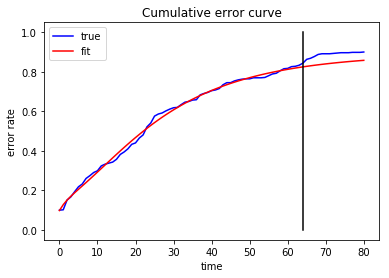

In [291]:
plt.plot(Y, "b-", y_pred, "r-") # Plot of the data and the fit
plt.title("Cumulative error curve")
plt.xlabel("time")
plt.ylabel("error rate")
plt.plot([points_to_learn, points_to_learn], [0, 1], 'k-')
plt.legend(('true', 'fit'), loc=2)
plt.show()

In [266]:
mean_absolute_error(y_train, y_pred[:points_to_learn]), \
        mean_absolute_error(y_test, y_pred[points_to_learn:]), \
        AcFP(y_test[-1], y_pred[-1])

(0.0096890626887579795, 0.018235904366913285, 4.5058908816475327)